# Testing urban zonification by hexagon

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download data

### Queretaro hexagons

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Queretaro'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban


<Axes: >

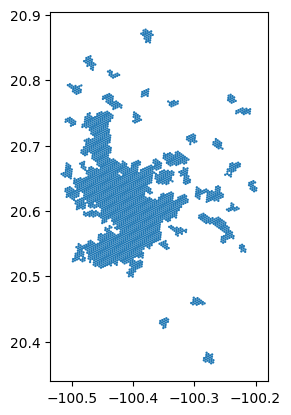

In [3]:
hex_gdf.plot()

### DENUE

In [4]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry('geometry')
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [5]:
folder_denue = 'denue'
table_denue = 'denue_23_point'

# download denue
query = f"SELECT * FROM {folder_denue}.{table_denue} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"

denue = aup.gdf_from_query(query, geometry_col='geometry')

print(denue.shape)
denue.head(4)

(61677, 43)


,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta,geometry
0,8283105.0,22014332320006711000000000U2,HERRERIA EN CASA,None,332320,Fabricación de productos de herrería,0 a 5 personas,PRIVADA,BENITO JUAREZ,PRIVADA,...,1602,18.0,4423787031,None,None,Fijo,20.761568,-100.427826,2019-11,POINT (-100.42783 20.76157)
1,8283203.0,22014312112001071000000000U1,AGUA PURIFICADOR SANTA ROSA,None,312112,Purificación y embotellado de agua,0 a 5 personas,CALLE,HACIENDA VISTA HERMOSA,CALLE,...,4310,40.0,4422696820,SANTAROSAA14@YAHOO.COM.MX,None,Fijo,20.765076,-100.436680,2019-11,POINT (-100.43668 20.76508)
2,3606748.0,22014332510000023000000000U4,RAPIDEZ Y PRECISION EN MAQUINADOS,RAPIDEZ Y PRECISION EN MAQUINADOS SA DE CV,332510,Fabricación de herrajes y cerraduras,11 a 30 personas,CALLE,IGNACIO ZARAGOZA,CALLE,...,1602,28.0,None,RPM_OF@YAHOO.COM.MX,None,Fijo,20.761156,-100.435850,2010-07,POINT (-100.43585 20.76116)
3,8793668.0,22014311830006951000000000U7,HERMANOS VEGA TORTILLERIA,None,311830,Elaboración de tortillas de maíz y molienda de...,0 a 5 personas,CALLE,MIGUEL HIDALGO,CALLE,...,1602,7.0,4422052760,None,None,Fijo,20.760954,-100.429220,2019-11,POINT (-100.42922 20.76095)


### Censo

In [18]:
folder_censo = 'censo'
tabla_censo = 'censo_inegi_20_mza'

# download denue
query = f"SELECT * FROM {folder_censo}.{tabla_censo} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"

mza_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mza_gdf = mza_gdf[['cvegeo_mza','pobtot','geometry']].copy()

print(mza_gdf.shape)
mza_gdf.head(4)

(19412, 3)


,cvegeo_mza,pobtot,geometry
0,2201400014715003,62,"POLYGON ((-100.48937 20.61097, -100.48938 20.6..."
1,2201400014715004,16,"POLYGON ((-100.49089 20.61082, -100.49091 20.6..."
2,2201400014715008,52,"POLYGON ((-100.48987 20.60933, -100.48999 20.6..."
3,2201400014715010,79,"POLYGON ((-100.49205 20.61332, -100.49206 20.6..."


In [22]:
mza_gdf = mza_gdf.to_crs("EPSG:6372")
mza_gdf['geometry'] = mza_gdf.centroid
mza_gdf = mza_gdf.to_crs("EPSG:4326")
mza_gdf['nombre_act'] = 'Habitacional'
mza_gdf = mza_gdf.rename(columns={'cvegeo_mza':'clee',
                                 'pobtot':'per_ocu_num'})

## Data treatment

In [6]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [7]:
denue['per_ocu_num'] = denue.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

In [11]:
denue['codigo_grl'] = denue.codigo_act.apply(lambda x: x[:-4])

In [8]:
clas_act = {'Industria':['31','32','33'],
           'Comercio':['43','46'],
           'Servicios':['52','53','54','55','56',
                       '72','81','93'],
            'Equipamiento':['61','62'],
            'Recreativo':['71'],
           'Otros':['11','21','22','23',
                    '51','48','49',],
           }

In [9]:
act_name = {}
for k,v in clas_act.items():
    for x in v:
        act_name.setdefault(x, []).append(k)

In [12]:
denue['nombre_act'] = denue.codigo_grl.apply(lambda x: act_name[x][0])

### Merge Pop and DENUE

In [23]:
mza_denue = pd.concat([denue[['clee','per_ocu_num','nombre_act','geometry']],
          mza_gdf])
print(mza_denue.shape)
mza_denue.head(2)

(81089, 4)


,clee,per_ocu_num,nombre_act,geometry
0,22014332320006711000000000U2,3,Industria,POINT (-100.42783 20.76157)
1,22014312112001071000000000U1,3,Industria,POINT (-100.43668 20.76508)


## Save data

In [24]:
hex_gdf.to_file('../../../data/processed/Distrito_QRO/hex_dro.geojson')
mza_denue.to_file('../../../data/processed/Distrito_QRO/mza_denue_qro.geojson')

## Hex Uso de suelo

In [25]:
hex_usosuelo = gpd.read_file('../../../data/processed/Distrito_QRO/hex_uso_suelo.geojson')
print(hex_usosuelo.shape)
hex_usosuelo.head(2)

(2826, 13)


,hex_id_9,CVEGEO,NOMGEO,city,type,comerciomean,equipmean,habmean,indmean,otromean,recreativomean,servmean,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.04298,0.0,561.548754,0.0,0.000000,0.0,0.0,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.00000,0.0,66.851812,0.0,0.285432,0.0,0.0,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [27]:
uso_list = ['comerciomean','equipmean','habmean',
           'indmean','otromean','recreativomean',
           'servmean']

In [28]:
hex_usosuelo['uso_tot'] = hex_usosuelo[uso_list].sum(axis=1)

In [29]:
for us in uso_list:
    hex_usosuelo['pct_'+us] = hex_usosuelo[us]/hex_usosuelo['uso_tot']

In [30]:
print(hex_usosuelo.shape)
hex_usosuelo.head(2)

(2826, 21)


,hex_id_9,CVEGEO,NOMGEO,city,type,comerciomean,equipmean,habmean,indmean,otromean,...,servmean,geometry,uso_tot,pct_comerciomean,pct_equipmean,pct_habmean,pct_indmean,pct_otromean,pct_recreativomean,pct_servmean
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.04298,0.0,561.548754,0.0,0.000000,...,0.0,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",561.591734,0.000077,0.0,0.999923,0.0,0.000000,0.0,0.0
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.00000,0.0,66.851812,0.0,0.285432,...,0.0,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",67.137244,0.000000,0.0,0.995749,0.0,0.004251,0.0,0.0


In [32]:
hex_usosuelo.to_file('../../../data/processed/Distrito_QRO/hex_pct_uso_suelo.geojson')